<a href="https://colab.research.google.com/github/dmdiegoar/Adv_Fin_ML_Exercises/blob/master/RAG_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================
# INSTALAR DEPENDENCIAS
# =============================================

!pip install -q sentence-transformers transformers accelerate
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.2 MB/s eta 0:00:00


In [ ]:
# =============================================
# IMPORTAR LIBRERÍAS
# =============================================

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import json
import matplotlib.pyplot as plt
import numpy as np

# Generador vectorial

In [ ]:
# =============================================
# CARGAR MODELO DE EMBEDDINGS
# =============================================

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Funciones de búsqueda

In [ ]:
# =============================================
# FUNCIÓN DE BÚSQUEDA SEMÁNTICA
# =============================================

def buscar_contexto(query, dataset, top_k=1):
    corpus = [d["doc"] for d in dataset]
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_result = torch.topk(cos_scores, k=top_k)

    resultados = []
    for idx in top_result.indices:
        resultados.append(dataset[idx]["context"])
    return resultados


# =============================================
# FUNCIÓN PARA GRAFICAR LAS DISTANCIAS ENTRE VECTORES
# =============================================
def graficar_distancias_angular(query, dataset, threshold=np.pi/4):
    corpus = [d["doc"] for d in dataset]
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

    # Codificar la query
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # Calcular similitud coseno entre la query y el corpus
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0].tolist()
    cos_threshold = np.cos(threshold_rad)

    print('Threshold (radianes):', threshold)
    print('Distancia coseno:')
    print([f"Doc {i+1}: {d}" for i, d in enumerate(cos_scores)])
    print()

    for idx, score in enumerate(cos_scores):
         if score >= cos_threshold:
             print('Document retrieved: ', corpus[idx])
             print('Context: ', dataset[idx]["context"])

    # Obtener los ángulos reales en radianes
    angles_rad = np.arccos(np.clip(cos_scores, -1.0, 1.0))

    # Crear gráfico polar
    fig = plt.figure(figsize=(7, 10))
    ax = fig.add_subplot(111, polar=True)

    # Crear el área estilo PAC-MAN desde threshold hasta 2π
    theta = np.linspace(threshold, 2 * np.pi, 500)
    r = np.ones_like(theta)
    theta = np.concatenate(([threshold], theta, [2 * np.pi], [threshold]))
    r = np.concatenate(([0], r, [0], [0]))
    ax.fill(theta, r, color='red', alpha=0.3,
            label=f'Ignorado')

    # Plotear la query (opcional: mostrar en ángulo 0 si la considerás fija)
    ax.plot([0, 0], [0, 1], label='Query', color='black',
            linewidth=2, linestyle='--', marker='o')

    # Etiquetas para los documentos
    labels = [f'Doc {i+1}' for i in range(len(cos_scores))]

    # Graficar cada documento con su ángulo real
    for angle, label in zip(angles_rad, labels):
        ax.plot([0, angle], [0, 1], label=label, marker='o')

    # Plot de la línea del threshold
    ax.plot([0, threshold], [0, 1], label='Corte', linestyle='--', color='gray')

    # Opcional: eliminar radios
    ax.set_yticklabels([])

    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.tight_layout()
    plt.show()


# Simulación base de datos AFIP

In [ ]:
dataset = [
    {
        "doc": "¿Cómo me doy de alta en el Monotributo?",
        "context": "Para darte de alta en el Monotributo, debes ingresar a la página de AFIP con tu clave fiscal, seleccionar 'Monotributo' y seguir los pasos que indica el sistema."
    },
    {
        "doc": "¿Qué categorías existen en el Monotributo?",
        "context": "Las categorías del Monotributo van desde la A hasta la K, y dependen de tus ingresos brutos anuales, superficie afectada y consumo eléctrico."
    },
    {
        "doc": "¿Qué es el régimen general IVA?",
        "context": "El régimen general implica inscribirse en IVA y Ganancias, a diferencia del Monotributo que simplifica el pago de impuestos. Este impuesto caduco en el año 2024 y ya no esta vigente."
    },
    {
        "doc": "¿Cómo facturar como profesional autónomo?",
        "context": "Debes estar inscrito en el régimen general, emitir factura electrónica desde el portal de AFIP y presentar declaraciones mensuales de IVA y Ganancias."
    }
]

# Retribución de documentos

Threshold (radianes): 0.5235987755982988
Distancia coseno:
['Doc 1: 0.5190156698226929', 'Doc 2: 0.3852856159210205', 'Doc 3: 0.9907946586608887', 'Doc 4: 0.4797951281070709']

Document retrieved:  ¿Qué es el régimen general IVA?
Context:  El régimen general implica inscribirse en IVA y Ganancias, a diferencia del Monotributo que simplifica el pago de impuestos. Este impuesto caduco en el año 2024 y ya no esta vigente.


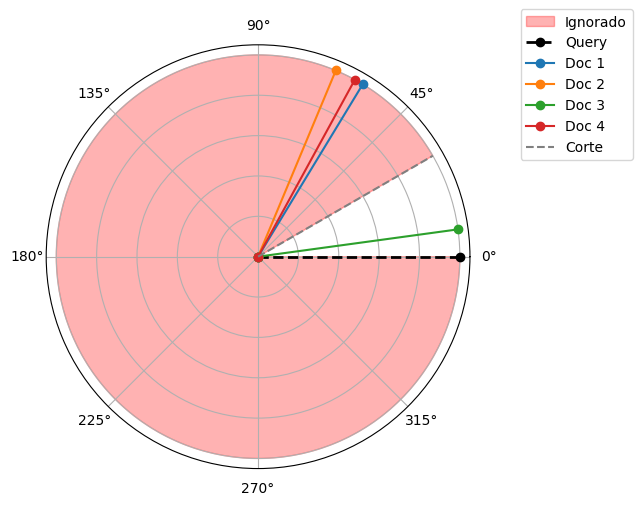

In [ ]:
query = '¿Qué es el régimen general de IVA?'

# Búsqueda por los K más cercanos sin discriminación por distancia
context = buscar_contexto(query, dataset)


# Búsqueda de los n resultados dentro de un intervalo de inclusión
threshold_rad = np.radians(30)
graficar_distancias_angular(query, dataset, threshold=threshold_rad)

# Selección de LLM

In [ ]:
import os
from huggingface_hub import InferenceClient

# Conseguir tu token de acceso a la API (https://huggingface.co/docs/hub/security-tokens)
# 1- Logearse en hugginface: https://huggingface.co/login?next=%2Fsettings%2Ftokens
# 2- Hacer click en "Create new Token"
# 3- Seleccionar token type "Read"
# 4- Asignarle un nombre cualquiera al token
# 5- Generar token y copiar el token

API_KEY = "Inserta tu token generado aca"

client = InferenceClient(api_key=API_KEY)

# Seleccionamos el modelo
#model = "deepseek-ai/DeepSeek-V3-0324"
model = "meta-llama/Llama-3.1-8B-Instruct"

# Flujo completo

In [ ]:
# Entra al sistema la query del usuario:

query = 'Cuales son las categorias del monotributo?'

# Buscamos los documentos asociados

context = buscar_contexto(query, dataset)

# Enviamos el contexto retribuido y la pregunta del usuario al LLM
completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": f"Utiliza unicamente el siguiente contexto para responder a la siguiente consulta: {context}."},
        {"role": "user", "content": query}
    ]
)

# Mostramos la respuesta
print(completion.choices[0].message.content)

Las categorías del Monotributo van desde la **A** hasta la **K**, determinadas por los ingresos brutos anuales, la superficie afectada y el consumo eléctrico del contribuyente. No hay más categorías fuera de ese rango alfabético.
